In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm  
from helpers import parse_vep_filename, plot_channels, load_vep_csv, load_dataset_paths
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)


In [2]:
### TODO: 
# Try wavelet packet decomposition (WPD) or short-time Fourier transform (STFT) for a richer spectral representation.
# Statistical & temporal features from DWT bands
# Instead of concatenating A4 and D4, test weighted feature fusion or decision-level fusion (combine separate classifiers for each band)


## 0. Loading Files and Metadata

In [3]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]
# mp20_files_BC_only = all_paths["MP20"]["BC_Only"]
# mp20_files_RGC_only = all_paths["MP20"]["RGC_Only"]
# mp20_files_BC_and_RGC = all_paths["MP20"]["BC_and_RGC"]


# Optional: make a DataFrame summary
summary = [
    {"device": dev, "label": lbl, "n_files": len(files)}
    for dev, labels in all_paths.items()
    for lbl, files in labels.items()
]
print(pd.DataFrame(summary))


  device       label  n_files
0  PRIMA     BC_Only      132
1  PRIMA    RGC_Only       66
2  PRIMA  BC_and_RGC       20
3   MP20     BC_Only       37
4   MP20    RGC_Only       10
5   MP20  BC_and_RGC        2


## 1. Preprocessing

In [4]:
import numpy as np
from scipy.signal import detrend, butter, filtfilt
import pywt

class Preprocessor:
    def __init__(self, fs, verbose=True):
        self.fs = fs  # Sampling frequency (Hz)
        self.verbose = verbose

    @staticmethod
    def convert_to_uV(signal, scale_factor=0.001):
        """Convert from nV to µV."""
        return np.asarray(signal, float) * scale_factor

    @staticmethod
    def average_signal_halves(signal):
        """Average two halves of the signal (for phase-locked averaging)."""
        even_len = len(signal) - (len(signal) % 2)
        signal = np.asarray(signal[:even_len])
        N = even_len // 2
        return (signal[:N] + signal[N:]) / 2

    @staticmethod
    def detrend_signal(signal, type="linear"):
        """Remove slow drifts."""
        return detrend(signal, type=type)
    
    def peak_to_peak_normalize(self, signal, window_ms=100):
        """Normalize to peak-to-peak amplitude in the first window_ms milliseconds."""
        window_samples = int((window_ms / 1000) * self.fs)
        p2p_amplitude = np.max(signal[:window_samples]) - np.min(signal[:window_samples])
        return signal if p2p_amplitude == 0 else signal / p2p_amplitude

    @staticmethod
    def normalize_signal(signal):
        """Normalize to max absolute value = 1."""
        max_val = np.max(np.abs(signal))
        return signal if max_val == 0 else signal / max_val
    
    def trim_signal(self, signal, trim_ms):
        """Trim the signal to a length of trim_ms milliseconds."""
        trim_samples = int((trim_ms / 1000) * self.fs)
        return signal[:trim_samples]

    def wavelet_denoise(self, signal, wavelet="db6", low_cut=0.1, high_cut=100):
        max_level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
        coeffs = pywt.wavedec(signal, wavelet, level=max_level)
        freqs = [self.fs / (2 ** (i + 1)) for i in range(len(coeffs))]  # approx upper freq per level

        kept = []
        for i, c in enumerate(coeffs):
            f = freqs[i] if i < len(freqs) else 0
            if i == 0:  # approximation band
                # Approx band corresponds to 0–(fs / 2^(max_level+1))
                f_low = self.fs / (2 ** (max_level + 1))
                if f_low < high_cut:  # keep low-freq info
                    kept.append(c)
                else:
                    kept.append(np.zeros_like(c))
            else:
                # Detail band corresponds roughly to fs/(2^(i+1))–fs/(2^i)
                f_high = self.fs / (2 ** i)
                f_low = self.fs / (2 ** (i + 1))
                if (f_high >= low_cut) and (f_low <= high_cut):
                    kept.append(c)
                else:
                    kept.append(np.zeros_like(c))
        denoised = pywt.waverec(kept, wavelet)
        return denoised[: len(signal)]

    def preprocess(self, ch1, ch3, trim_ms=500):
        # Conversion
        ch1 = self.convert_to_uV(ch1)
        ch3 = self.convert_to_uV(ch3)

        # Average halves
        if len(ch1) > 10:
            ch1 = self.average_signal_halves(ch1)
            ch3 = self.average_signal_halves(ch3)

        # Wavelet denoising
        ch3 = self.wavelet_denoise(ch3, wavelet="db6")

        # detrending
        ch3 = self.detrend_signal(ch3)

        # trimming
        ch3 = self.trim_signal(ch3, trim_ms=trim_ms)

        # Nornmalize to max absolute amplitude
        #ch3 = self.peak_to_peak_normalize(ch3, window_ms=100)
        ch3 = self.normalize_signal(ch3)
        return ch3

def process_file(file_path, label, fs, trim_ms=500):
    info = parse_vep_filename(os.path.basename(file_path))
    data_raw, _ = load_vep_csv(file_path)
    ch1 = data_raw["Chan 1"].to_numpy()
    ch3 = data_raw["Chan 3"].to_numpy()
    ch3_proc = Preprocessor(fs).preprocess(ch1, ch3, trim_ms=trim_ms)
    # Collect minimal features (per signal)
    features = {
        "label": label
    }
    return features, ch3_proc

100%|██████████| 20/20 [00:00<00:00, 298.37it/s]


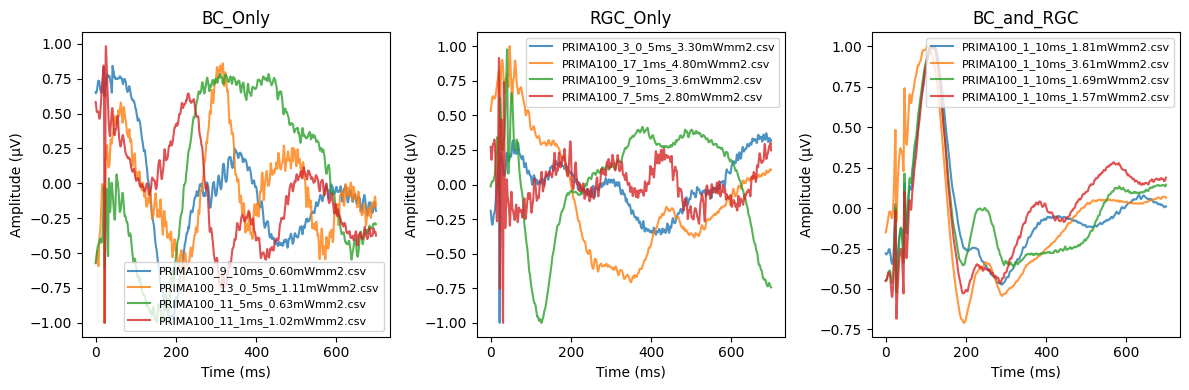

In [5]:
# ---- collect all data ----
fs = 2000  # sampling frequency
all_features = []
all_signals = []  # this was missing before!

# try prima and mp20 together
BC_only_files = prima_files_BC_only 
RGC_only_files = prima_files_RGC_only 
BC_and_RGC_files = prima_files_BC_and_RGC 


for f in tqdm(BC_only_files):  # to match sizes
    feats, sig = process_file(f, "BC_Only", fs, trim_ms=700)
    feats["filename"] = os.path.basename(f)
    all_features.append(feats)
    all_signals.append(sig)

for f in tqdm(RGC_only_files):  # to match sizes
    feats, sig = process_file(f, "RGC_Only", fs, trim_ms=700)
    feats["filename"] = os.path.basename(f)
    all_features.append(feats)
    all_signals.append(sig)

for f in tqdm(BC_and_RGC_files):
    feats, sig = process_file(f, "BC_and_RGC", fs, trim_ms=700)
    feats["filename"] = os.path.basename(f)
    all_features.append(feats)
    all_signals.append(sig)


# plot one example signal from each class
plt.figure(figsize=(12, 4))
labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
if all_signals:
    # Get the length of the *trimmed* signal (which should be 1000)
    num_samples = len(all_signals[0]) 
    # Create a time vector in milliseconds
    time_vector_ms = np.arange(num_samples) / fs * 1000 
else:
    time_vector_ms = [] # Handle empty list case

for i, label in enumerate(labels, 1):
    plt.subplot(1, 3, i)
    count = 0
    for feat, sig in zip(all_features, all_signals):
        if feat["label"] == label:
            # PLOT AGAINST THE TIME VECTOR instead of the sample indices
            plt.plot(time_vector_ms, sig, alpha=0.8, label=feat["filename"]) 
            count += 1
            if count >= 4:
                break
    plt.title(label)
    # Change the x-label to reflect the units
    plt.xlabel("Time (ms)") 
    plt.ylabel("Amplitude (µV)")
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 2. DWT feature extraction

In [6]:
def extract_dwt_subbands(signal, wavelet='dmey', level=4):
    """
    Extracts the 4th-level approximation (A4) and detail (D4)
    from a DWT decomposition using 'dmey' wavelet.
    Returns A4 and D4 as arrays for later dimensionality reduction.
    """
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    A4, D4, D3, D2, D1 = coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4]  # wavedec returns [A4, D4, D3, D2, D1]
    return A4, D4, D3, D2, D1

# apply per signal
A4_list, D4_list, D3_list, D2_list, D1_list = [], [], [], [], []
for sig in all_signals:
    a4, d4, d3, d2, d1 = extract_dwt_subbands(sig)
    A4_list.append(a4)
    D4_list.append(d4)
    D3_list.append(d3)
    D2_list.append(d2)
    D1_list.append(d1)

signals = {
    "A4": np.vstack(A4_list),
    "D4": np.vstack(D4_list),
}
A4_array = signals["A4"]
D4_array = signals["D4"]
labels = np.array([f["label"] for f in all_features])


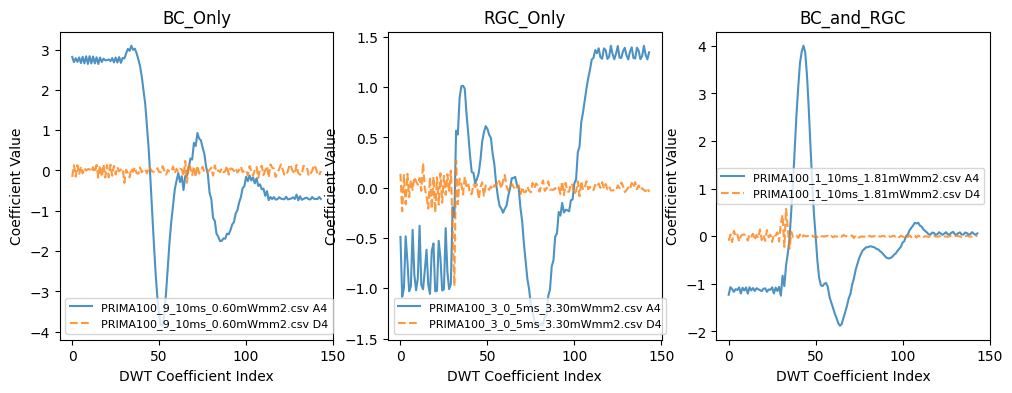

In [7]:
# plot example DWT coefficients
plt.figure(figsize=(12, 4))
plot_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
for i, label in enumerate(plot_labels, 1):
    plt.subplot(1, 3, i)
    count = 0
    for feat, a4, d4 in zip(all_features, A4_array, D4_array):
        if feat["label"] == label:
            plt.plot(a4, alpha=0.8, label=f"{feat['filename']} A4")
            plt.plot(d4, alpha=0.8, linestyle='--', label=f"{feat['filename']} D4")
            count += 1
            if count >= 1:
                break
    plt.title(label)
    plt.xlabel("DWT Coefficient Index")
    plt.ylabel("Coefficient Value")
    plt.legend(fontsize=8)

## 3. Dimensionality Reduction

In [8]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import FastICA
import umap

class DimensionalityReducer:
    def __init__(self, n_pca=6, n_lda=2, n_ica=6, random_state=42):
        self.n_pca = n_pca
        self.n_lda = n_lda
        self.n_ica = n_ica
        self.random_state = random_state

    def pca(self, X_train, X_test):
        pca = PCA(n_components=self.n_pca, random_state=self.random_state)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        return X_train_pca, X_test_pca
    
    def kernel_pca(self, X_train, X_test, kernel='rbf'):
        kpca = KernelPCA(n_components=self.n_pca, kernel=kernel, random_state=self.random_state)
        X_train_kpca = kpca.fit_transform(X_train)
        X_test_kpca = kpca.transform(X_test)
        return X_train_kpca, X_test_kpca

    def lda(self, X_train, y_train, X_test):
        lda = LinearDiscriminantAnalysis(n_components=self.n_lda)
        X_train_lda = lda.fit_transform(X_train, y_train)
        X_test_lda = lda.transform(X_test)
        return X_train_lda, X_test_lda
    
    def qda(self, X_train, y_train, X_test):
        qda = QuadraticDiscriminantAnalysis()
        qda.fit(X_train, y_train)
        X_train_qda = qda.predict_proba(X_train)
        X_test_qda = qda.predict_proba(X_test)
        return X_train_qda, X_test_qda

    def ica(self, X_train, X_test):
        ica = FastICA(n_components=self.n_ica, random_state=self.random_state)
        X_train_ica = ica.fit_transform(X_train)
        X_test_ica = ica.transform(X_test)
        return X_train_ica, X_test_ica

    def umap(self, X_train, X_test):
        reducer = umap.UMAP(random_state=self.random_state, n_neighbors=10, min_dist=0.05, metric='cosine')
        X_train_umap = reducer.fit_transform(X_train)
        X_test_umap = reducer.transform(X_test)
        return X_train_umap, X_test_umap
    
    def plot_projection(self, X_proj, y, title="Projection to Components", method="PCA", labels_unique=None):
        """
        Plot the 2D projection of the reduced data.
        Works for PCA, LDA, ICA, etc.
        """
        X_proj = np.array(X_proj)
        if X_proj.shape[1] < 2:
            raise ValueError("Need at least 2 components to plot 2D projection.")

        if labels_unique is None:
            labels_unique = np.unique(y)

        cmap = plt.cm.get_cmap('viridis', len(labels_unique))
        colors = [cmap(i) for i in range(len(labels_unique))]
        plt.figure(figsize=(7, 6))
        for i, lbl in enumerate(labels_unique):
            mask = np.array(y) == lbl
            plt.scatter(
                X_proj[mask, 0],
                X_proj[mask, 1],
                color=colors[i],
                label=str(lbl),
                s=60,
            )

        plt.title(f"{title} ({method})")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## 4. Classification

In [9]:
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


class Classifier:
    def __init__(self, X, y, clf="LogisticRegression", n_splits=10, random_state=42, dim_reducer=None):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.random_state = random_state
        self.dim_reducer = dim_reducer
        self.cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        self.gridsearch = False
        self.is_cnn = False
        if clf == "LogisticRegression":
            self.clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=self.random_state, class_weight='balanced')
        elif clf == "SVM":
            #self.clf = LinearSVC(random_state=self.random_state)
            self.clf= SVC(kernel="rbf", class_weight="balanced")
            self.gridsearch = True
            #self.clf = SVC(kernel='rbf', gamma='scale', class_weight='balanced', probability=True, random_state=self.random_state)
        elif clf == "MLP":
            self.clf = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', max_iter=2000)
        elif clf == "1DCNN":
            self.is_cnn = True
            self.clf = None

    def build_cnn(self, input_shape, n_classes):
        model = Sequential([
            Conv1D(16, kernel_size=5, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Conv1D(32, kernel_size=3, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(n_classes, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def fit(self, use_pca=True, use_lda=True, use_qda=False, use_ica=False, use_kernel_pca=False, use_umap=False):
        y_true, y_pred = [], []
        # Determine if data is dict-like (A4/D4 bands)
        is_dualband = isinstance(self.X, dict)
        if is_dualband:
            X_A4 = self.X["A4"]
            X_D4 = self.X["D4"]

        for i, (train_idx, test_idx) in enumerate(self.cv.split(self.y, self.y)):
            if is_dualband:
                X_train_A4, X_test_A4 = X_A4[train_idx], X_A4[test_idx]
                X_train_D4, X_test_D4 = X_D4[train_idx], X_D4[test_idx]
            else:
                X_train, X_test = self.X[train_idx], self.X[test_idx]
            y_train, y_test = self.y[train_idx], self.y[test_idx]

            # --- Scaler---
            scaler = StandardScaler()
            if is_dualband:
                X_train_A4 = scaler.fit_transform(X_train_A4)
                X_test_A4 = scaler.transform(X_test_A4)
                X_train_D4 = scaler.fit_transform(X_train_D4)
                X_test_D4 = scaler.transform(X_test_D4)
            else:
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            # ---- Dimensionality Reduction ----
            if self.dim_reducer is not None and not self.is_cnn:
                if is_dualband:
                    if use_pca:
                        X_train_A4, X_test_A4 = self.dim_reducer.pca(X_train_A4, X_test_A4)
                        X_train_D4, X_test_D4 = self.dim_reducer.pca(X_train_D4, X_test_D4)
                    if use_lda:
                        X_train_A4, X_test_A4 = self.dim_reducer.lda(X_train_A4, y_train, X_test_A4)
                        X_train_D4, X_test_D4 = self.dim_reducer.lda(X_train_D4, y_train, X_test_D4)
                    if use_ica:
                        X_train_A4, X_test_A4 = self.dim_reducer.ica(X_train_A4, X_test_A4)
                        X_train_D4, X_test_D4 = self.dim_reducer.ica(X_train_D4, X_test_D4)
                    if use_kernel_pca:
                        X_train_A4, X_test_A4 = self.dim_reducer.kernel_pca(X_train_A4, X_test_A4)
                        X_train_D4, X_test_D4 = self.dim_reducer.kernel_pca(X_train_D4, X_test_D4)
                    if use_umap:
                        X_train_A4, X_test_A4 = self.dim_reducer.umap(X_train_A4, X_test_A4)
                        X_train_D4, X_test_D4 = self.dim_reducer.umap(X_train_D4, X_test_D4)

                    X_train = np.hstack([X_train_A4, X_train_D4])
                    X_test = np.hstack([X_test_A4, X_test_D4])
                else:
                    if use_pca:
                        X_train, X_test = self.dim_reducer.pca(X_train, X_test)
                    if use_lda:
                        X_train, X_test = self.dim_reducer.lda(X_train, y_train, X_test)
                    if use_ica:
                        X_train, X_test = self.dim_reducer.ica(X_train, X_test)
                    if use_kernel_pca:
                        X_train, X_test = self.dim_reducer.kernel_pca(X_train, X_test)
            else:
                if is_dualband:
                    X_train = np.hstack([X_train_A4, X_train_D4])
                    X_test = np.hstack([X_test_A4, X_test_D4])


            # if self.gridsearch:
            #     param_grid = {
            #         "C": [0.1, 1, 10, 100],
            #         "gamma": [1e-3, 1e-2, 1e-1, 1, "scale"],
            #     }
            #     grid = GridSearchCV(self.clf, param_grid, scoring="balanced_accuracy", cv=5)
            #     grid.fit(X_train, y_train)
            #     print("Best params:", grid.best_params_)

            if self.is_cnn:
                n_classes = len(np.unique(self.y))
                y_train_cat = to_categorical(pd.Series(y_train).astype("category").cat.codes, num_classes=n_classes)
                y_test_cat = to_categorical(pd.Series(y_test).astype("category").cat.codes, num_classes=n_classes)

                X_train_cnn = np.expand_dims(X_train, axis=-1)
                X_test_cnn = np.expand_dims(X_test, axis=-1)
                input_shape = X_train_cnn.shape[1:]

                cnn = self.build_cnn(input_shape, n_classes)
                cnn.fit(X_train_cnn, y_train_cat, epochs=25, batch_size=16, verbose=0)
                preds = cnn.predict(X_test_cnn)
                y_pred_fold = np.argmax(preds, axis=1)
                label_decoder = dict(enumerate(pd.Series(self.y).astype("category").cat.categories))
                y_pred.extend([label_decoder[i] for i in y_pred_fold])
                y_true.extend(y_test)
            else:
                # ---- Traditional classifier ----
                self.clf.fit(X_train, y_train)
                y_pred.extend(self.clf.predict(X_test))
                y_true.extend(y_test)

        return np.array(y_true), np.array(y_pred)
    
    def evaluate(self, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        report = classification_report(y_true, y_pred, target_names=np.unique(self.y), digits=3)
        return {
            "accuracy": acc,
            "balanced_accuracy": bal_acc,
            "f1_score": f1,
            "confusion_matrix": cm,
            "classification_report": report
        }

## 5. Test

In [10]:
from pprint import pprint

# Initialize reducer and classifier
dim_reducer = DimensionalityReducer(n_pca=10, n_lda=2, n_ica=6, random_state=42)

# --- Define experiments ---
experiments = [
    {"name": "No Reduction", "pca": False, "lda": False, "qda": False, "ica": False, "kernel_pca": False},
    {"name": "PCA only", "pca": True, "lda": False, "qda": False, "ica": False, "kernel_pca": False},
    {"name": "LDA only", "pca": False, "lda": True, "qda": False, "ica": False, "kernel_pca": False},
    {"name": "PCA + LDA", "pca": True, "lda": True, "qda": False, "ica": False, "kernel_pca": False},
    {"name": "ICA only", "pca": False, "lda": False, "qda": False, "ica": True, "kernel_pca": False},
    {"name": "Kernel PCA only", "pca": False, "lda": False, "qda": False, "ica": False, "kernel_pca": True},
    {"name": "UMAP only", "pca": False, "lda": False, "qda": False, "ica": False, "kernel_pca": False, "umap": True}
]

results = []
for clf_name in ["LogisticRegression", "SVM", "MLP", "1DCNN"]:
    print(f"\n=== Testing {clf_name} ===")
    for exp in experiments:
        if clf_name == "1DCNN" and exp != experiments[0]:
            continue 
        # print("\n" + "=" * 60)
        # print(f"Running experiment: {exp['name']}")
        # print("=" * 60)
        clf = Classifier(signals, labels, clf=clf_name, n_splits=10, random_state=42, dim_reducer=dim_reducer)
        y_true, y_pred = clf.fit(
            use_pca=exp["pca"],
            use_lda=exp["lda"],
            use_qda=exp["qda"],
            use_ica=exp["ica"],
            use_kernel_pca=exp["kernel_pca"],
        )
        metrics = clf.evaluate(y_true, y_pred)
        results.append({"classifier": clf_name, "experiment": exp["name"], **metrics})
        #print(metrics["classification_report"])

# print summary of results as pandas DataFrame
print("\n\n=== Summary of Results ===")
summary_df = pd.DataFrame(results)
print(summary_df)


=== Testing LogisticRegression ===


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tole


=== Testing SVM ===


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tole


=== Testing MLP ===


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: Converg


=== Testing 1DCNN ===


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


=== Summary of Results ===
            classifier       experiment  accuracy  balanced_accuracy  \
0   LogisticRegression     No Reduction  0.605505           0.686364   
1   LogisticRegression         PCA only  0.642202           0.716667   
2   LogisticRegression         LDA only  0.605505           0.700505   
3   LogisticRegression        PCA + LDA  0.655963           0.721717   
4   LogisticRegression         ICA only  0.633028           0.704040   
5   LogisticRegression  Kernel PCA only  0.733945           0.791414   
6   LogisticRegression        UMAP only  0.605505           0.686364   
7                  SVM     No Reduction  0.761468           0.797475   
8                  SVM         PCA only  0.756881           0.802525   
9                  SVM         LDA only  0.577982           0.661111   
10                 SVM        PCA + LDA  0.683486           0.759596   
11                 SVM         ICA only  0.697248           0.767172 